<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P2.3_Metric_learning_image_retrieval_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Practical Overview

 In this practical you will learn :
- What is `Cifar 10` dataset and how to download the dataset through PyTorch.
- How to build triplet-net from scratch.
- How to select informative triplets.
- How to perform image retrieval tasks.


The practicals include:
- Design the embedding net of the triplet model that transforms data to an embeddings space.
- Complete the triplet Loss. 
- Complete the triplets selection strategy.
- Perform the image retrieval task and make comparison with results under different selection strategies


**Hint**:  

The training epoch numbers, learning rate, margin value, optimization method, and function structure/name in this notebook are just for reference, feel free to modify them.


# Preparing dataset


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<center><img src="https://raw.githubusercontent.com/vlamen/tue-deeplearning/main/img/cifar10.png" alt="Cifar_10" width="500"/></center>

Before we begin, let us first prepare our data. Luckily enough, we can simply download the dataset through PyTorch and have everything set up for us but you can also download the dataset from here [Cifar 10](https://www.cs.toronto.edu/~kriz/cifar.html):

Before we load our data, we need to first prepare the transformations to be applied to it. This is a necessary step to prepare the data for training

In [2]:
import torchvision
from torchvision import transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform)

Files already downloaded and verified


Let's check the 10 different classes.

In [5]:
classes=train_dataset.classes

print (classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


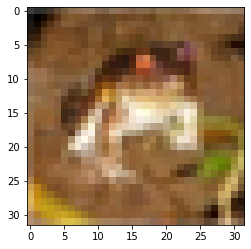

Label frog


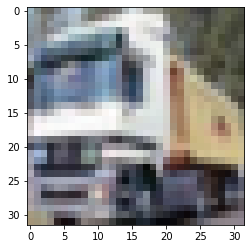

Label truck


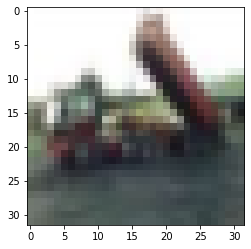

Label truck


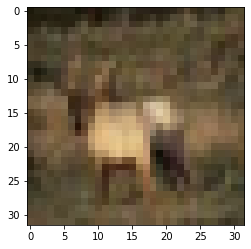

Label deer


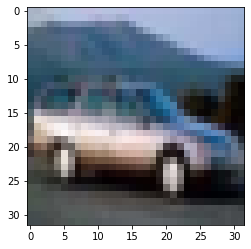

Label automobile


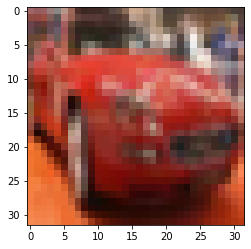

Label automobile


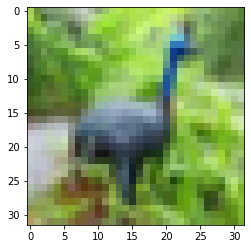

Label bird


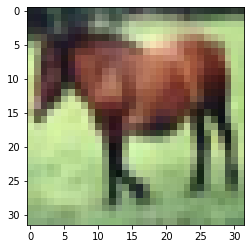

Label horse


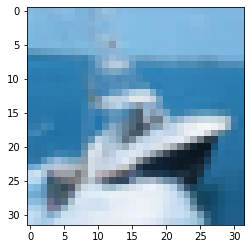

Label ship


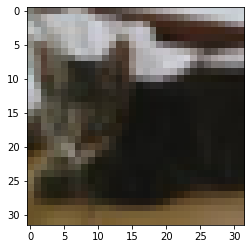

Label cat


In [6]:
#Let's visualize some example images


import matplotlib.pyplot as plt
for i in range (10):
    plt.imshow(train_dataset.data[i])
    plt.show()
    print ("Label",train_dataset.classes[train_dataset.targets[i]])
        


# Triplet Network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.


<center><img src="https://raw.githubusercontent.com/vlamen/tue-deeplearning/main/img/a_n_p.png" alt="Anchor_postive_negative_example" width="500"/></center>

*Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)$


**Hint**:  Please reference notebook chapter 4.5.2 `One-shot/metric learning` for more detail



## Steps

1. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** , to extract embedding of each sample (anchor, positive and negative image ) in triplets.

2. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples for each class to form a minibatch, and create a dataloader with the batch sampler. 

3. Define a **TripletSelector** that return triplets combinations by the samples from  **BalancedBatchSampler** 

4. Define **TripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on  triplets
5. Train the network!

##  Embedding Net

 **EmbeddingNet** is the branch of the triplet model that transforms data to an embeddings space. Try to complete the convolution neural network.
 

 **Hint**  :
 
(1) You could use `nn.Conv2d`,`nn.BatchNorm2d`,`nn.ReLU`,`nn.MaxPool2d`,`nn.Linear`,from `torch`. Try to choose the proper the `kernel_size` and `in_channels`,`out_channels`,`stride`.
    
(2) If the model is too shallow, it could collapse to one single point.


(3) PyTorch doesn't have a view layer, and we need to create one for our network. Lambda will create a layer that we can then use when defining a network with Sequential.

```py
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
```

The view layer could be written as:
```py
Lambda(lambda x: x.view(x.size(0), -1))
```


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
  

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

## Balanced Batch Sampler and Data Loader

Let's create `BalancedBatchSampler` to create a minibatch that contains  $N$ classes and $M$ samples for each class.

In [8]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

Then we create dataloader with the help of `torch.utils.data.DataLoader`

In [9]:
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.targets, n_classes=10, n_samples=25)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

## Random Triplet Selector

For the images in a minibatch, we exhaust all the anchor-positive pairs, but random choose one negative example for each positive pair to create triplets

In [10]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


## Triplet Loss

Recall the triplets funtion:

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

Let's write the loss accordingly.

Note that, triplets are generated using triplet_selector object that takes embeddings and targets and returns indices of triplets

**Hint**:  Please reference notebook chapter 4.5.2 `One-shot/metric learning` for more detail

In [11]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

## Training the  model

Next let's train the model. First, we recall the `Trainer` class from tutorial P2.2

In [12]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):


        for epoch in tqdm(range(self.epochs)):
                 


            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)


                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

Let's train the model

In [13]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:32<04:55, 32.87s/it]

EPOCH: 01/10 LOSS: 0.8794 VAL-LOSS: 0.6942


 20%|██        | 2/10 [01:05<04:23, 32.95s/it]

EPOCH: 02/10 LOSS: 0.6531 VAL-LOSS: 0.6251


 30%|███       | 3/10 [01:39<03:51, 33.00s/it]

EPOCH: 03/10 LOSS: 0.5881 VAL-LOSS: 0.5698


 40%|████      | 4/10 [02:12<03:18, 33.09s/it]

EPOCH: 04/10 LOSS: 0.5454 VAL-LOSS: 0.5479


 50%|█████     | 5/10 [02:45<02:45, 33.12s/it]

EPOCH: 05/10 LOSS: 0.5145 VAL-LOSS: 0.5226


 60%|██████    | 6/10 [03:18<02:12, 33.12s/it]

EPOCH: 06/10 LOSS: 0.4928 VAL-LOSS: 0.5081


 70%|███████   | 7/10 [03:51<01:39, 33.15s/it]

EPOCH: 07/10 LOSS: 0.4708 VAL-LOSS: 0.4929


 80%|████████  | 8/10 [04:25<01:06, 33.16s/it]

EPOCH: 08/10 LOSS: 0.4481 VAL-LOSS: 0.4740


 90%|█████████ | 9/10 [04:58<00:33, 33.15s/it]

EPOCH: 09/10 LOSS: 0.4199 VAL-LOSS: 0.4608


100%|██████████| 10/10 [05:31<00:00, 33.13s/it]

EPOCH: 10/10 LOSS: 0.3852 VAL-LOSS: 0.4253


Let's write a help funtion to extract the embedding

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

def extract_embeddings(dataloader, model):
    
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 10))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader, model)
val_embeddings, val_labels = extract_embeddings(test_loader, model)

Then we can visualise the embedding by dimension reduction using `Tsne`

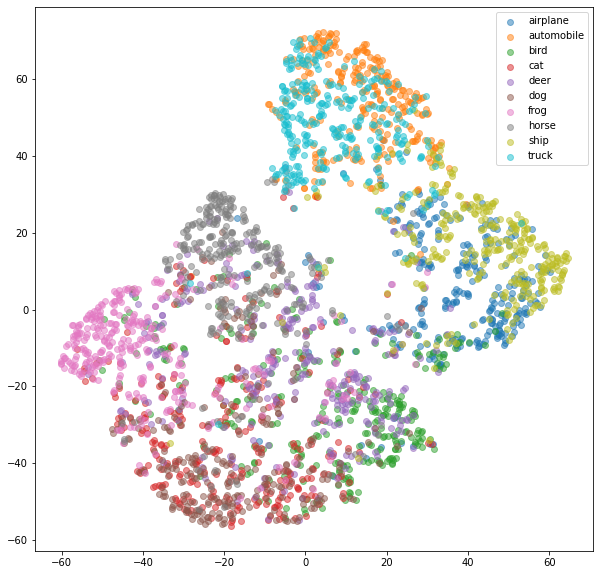

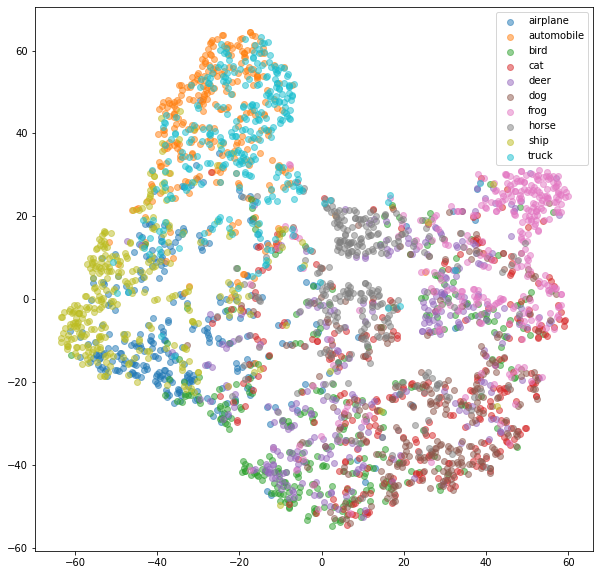

In [15]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):
    
    
    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction 
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

plot_tsne_embeddings(train_embeddings, train_labels)
plot_tsne_embeddings(val_embeddings, val_labels)

## Refactor the TripletSelector to Select Informative Triplets

Based on the definition of the loss, there are three categories of triplets:


  *  easy triplets: triplets which have a loss of 0, because `d(a,p)+margin<d(a,n)`
  *  hard triplets: triplets where the negative is closer to the anchor than the positive, i.e. `d(a,n)<d(a,p)`
  *  semi-hard triplets: triplets where the negative is not closer to the anchor than the positive, but which still have positive loss ` d(a,p)<d(a,n)<d(a,p)+margin`
 

Each of these definitions depend on where the negative is, relatively to the anchor and positive. We can therefore extend these three categories to the negatives: hard negatives, semi-hard negatives or easy negatives.

The figure below shows the three corresponding regions of the embedding space for the negative:



<center><img src="https://raw.githubusercontent.com/vlamen/tue-deeplearning/main/img/triplets.png" alt="triplets" width="500"/></center>

Our goal is to mining `hard triplets` and `semi-hard triplets`, i.e. `loss_values > 0`, because they are both informative.  To be specific, for the images in a minibatch, we exhaust all the anchor-positive pairs, for each positive pair we randomly choose one negative example in the `hard negatives` or `semi-hard negatives` to create `hard triplet` or `semi-hard triplet`.

First, let's create a help function to get the distances matrix of embeddings

In [16]:

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [17]:

class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None
    

    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            #randomly choose one negative example in the mined informative examples (semihard or hard negative samples) such that the triplets formed is semihard or hard triplet.
            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

            if len(triplets) == 0:
                triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)
        

Then we train the model with the mined triplets.

In [18]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
mined_embedding_net = EmbeddingNet()
mined_model = mined_embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(mined_model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=mined_model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [01:49<16:29, 109.95s/it]

EPOCH: 01/10 LOSS: 0.9886 VAL-LOSS: 0.9790


 20%|██        | 2/10 [03:40<14:40, 110.01s/it]

EPOCH: 02/10 LOSS: 0.9806 VAL-LOSS: 0.9750


 30%|███       | 3/10 [05:31<12:52, 110.31s/it]

EPOCH: 03/10 LOSS: 0.9841 VAL-LOSS: 0.9975


 40%|████      | 4/10 [07:21<11:02, 110.47s/it]

EPOCH: 04/10 LOSS: 0.9756 VAL-LOSS: 0.9604


 50%|█████     | 5/10 [09:12<09:13, 110.63s/it]

EPOCH: 05/10 LOSS: 0.9619 VAL-LOSS: 0.9608


 60%|██████    | 6/10 [11:03<07:22, 110.65s/it]

EPOCH: 06/10 LOSS: 0.9576 VAL-LOSS: 1.0034


 70%|███████   | 7/10 [12:54<05:32, 110.68s/it]

EPOCH: 07/10 LOSS: 0.9555 VAL-LOSS: 1.1497


 80%|████████  | 8/10 [14:44<03:41, 110.53s/it]

EPOCH: 08/10 LOSS: 0.9506 VAL-LOSS: 1.0919


 90%|█████████ | 9/10 [16:34<01:50, 110.31s/it]

EPOCH: 09/10 LOSS: 0.9471 VAL-LOSS: 1.1563


100%|██████████| 10/10 [18:23<00:00, 110.30s/it]

EPOCH: 10/10 LOSS: 0.9390 VAL-LOSS: 1.2192


And  visualise the embedding by dimension reduction using Tsne

In [19]:
m_train_embeddings, m_train_labels = extract_embeddings(train_loader, mined_model)
m_val_embeddings, m_val_labels = extract_embeddings(test_loader, mined_model)

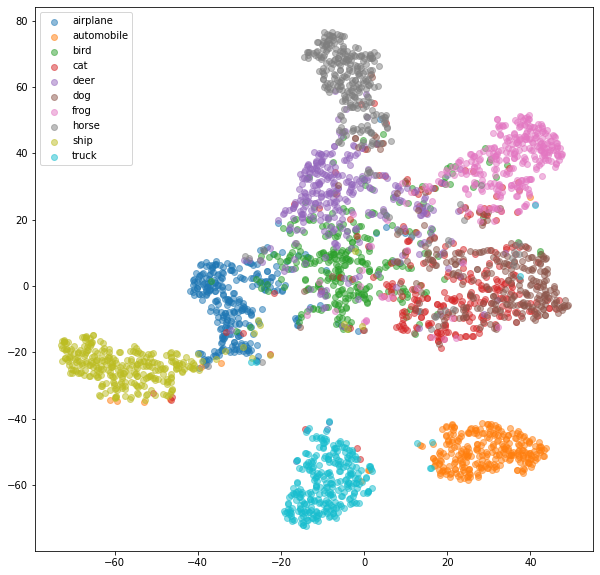

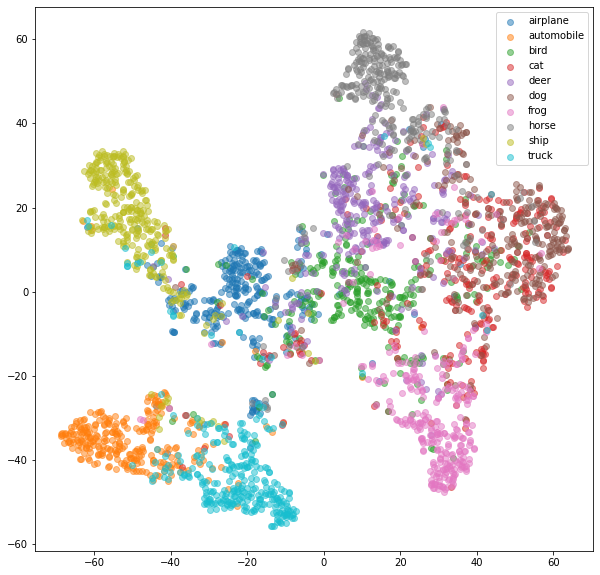

In [20]:
plot_tsne_embeddings(m_train_embeddings, m_train_labels)
plot_tsne_embeddings(m_val_embeddings, m_val_labels)

# Image Retrieval

We are now using the trained model for image retrieval on the `test images`. 
We are considering, in turn, single images from `test images` as query image, and the remaining 9,999 images as retrieval database.
The task of image retrieval (IR) is to find the *K* most similar images to the query image by Euclidean distance.


In purpose of this practical is:

1.  Perform image retrieval for the first *10* images from `test images`. Retrieve the *K=5* most similar images for each query (first *10* image). Show the query image and the retrieved images next to each other, and print their labels

2.   Compute and report the *mean average precision* (mAP), by computing  the *average precision* (AP) for each image in `test images`, and taking the mean AP over all 10,000 images.

3.  Compare the results of random triplets selection and  informative triplets selection 

Hints:


*   The AP is defined as follows.
  *   Let *TP* be the number of *true positives*, that is, the number of retrieved images which have the *same* label as the query image.
  *   Let *FP* be the number of *false positives*, that is, the number of retrieved images which have a *different* label than the query image.
  *   Let *FN* be the number of *false negatives*, that is, the number of *non-retrieved* images, which have the *same* label as the query image.
  *   The *precision* of an IR algorithm is defined as *precision* := TP / (TP + FP).   
  *   The *recall* is defined as *recall* := TP / (TP + FN).
  *   Precision will be high if you carefully select very few objects, where you are sure that these are needles. But recall will be low then. Recall will be high if you just grab and return the whole images. But precision will be low then. Thus, precision and recall are (usually) opposed to each other and represent a trade-off.
  * This trade-off can typically be governed by some hyper-parameter, in our case *K*, the number of retrieved images. For large *K*, we have large recall but low precision, for small *K* we have higher precision but low recall.
  * The trade-off can be inspected by looking at the precision-recall curve. The AP is defined as area under the precision-recall curve.
  *   Fortunately, an estimator of AP is already implemented for you in the function *average_precision*. It takes two arguments:
     *  sorted_class_vals: list of **class values** of the 9,999 other images, sorted according to closeness to the query image (closest first, most distant last).
     *  true_class: the class values of the query image.

In [21]:
def average_precision(sorted_class_vals, true_class):
    ind = sorted_class_vals == true_class
    num_positive = np.sum(ind)
    cum_ind = np.cumsum(ind).astype(np.float32)
    enum = np.array(range(1, len(ind)+1)).astype(np.float32)
    return np.sum(cum_ind * ind / enum) / num_positive

## Performing Image Retrieval with Random Triplets Selection Model

Let us perform image retrieval for the first 10 images from test data. Retrieve the K=5 most similar images for each query. 

First, lets extract the embedding by funtion `extract_embeddings`

In [30]:
val_embeddings, val_labels = extract_embeddings(test_loader, model)

We compute the distances matrix

In [31]:
from scipy.spatial.distance import cdist
distances=cdist(val_embeddings,val_embeddings)

Then we load the test images and test labels

In [32]:
test_labels=np.array(test_dataset.targets)
test_images=test_dataset.data


Plot the results

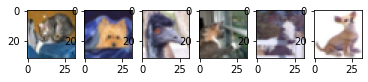

True class:
cat
Top 5 predicted:
['dog', 'bird', 'cat', 'horse', 'dog']
Average precision 0.2957694633109672



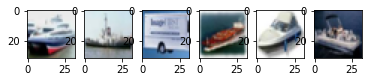

True class:
ship
Top 5 predicted:
['ship', 'truck', 'ship', 'ship', 'ship']
Average precision 0.5754451961727353



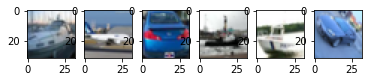

True class:
ship
Top 5 predicted:
['airplane', 'automobile', 'ship', 'ship', 'automobile']
Average precision 0.3629553931372779



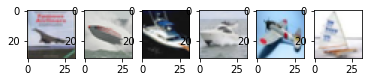

True class:
airplane
Top 5 predicted:
['ship', 'ship', 'ship', 'airplane', 'ship']
Average precision 0.4056166456984328



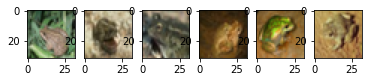

True class:
frog
Top 5 predicted:
['frog', 'frog', 'frog', 'frog', 'frog']
Average precision 0.44706455723301425



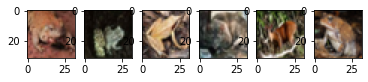

True class:
frog
Top 5 predicted:
['frog', 'frog', 'cat', 'deer', 'frog']
Average precision 0.4828875811847003



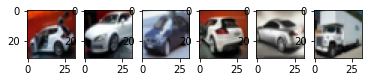

True class:
automobile
Top 5 predicted:
['automobile', 'automobile', 'automobile', 'automobile', 'truck']
Average precision 0.46453903244064376



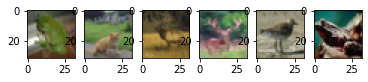

True class:
frog
Top 5 predicted:
['cat', 'deer', 'deer', 'bird', 'frog']
Average precision 0.1638280736791479



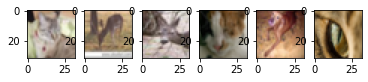

True class:
cat
Top 5 predicted:
['deer', 'deer', 'cat', 'dog', 'cat']
Average precision 0.2856679005665822



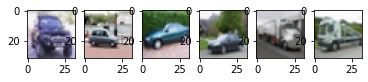

True class:
automobile
Top 5 predicted:
['automobile', 'automobile', 'automobile', 'truck', 'truck']
Average precision 0.49871847555563376



In [33]:
for k in range(10):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]

    plt.subplot(1, 6, 1)
    plt.imshow(test_dataset.data[k])
    for l in range(5):
      plt.subplot(1, 6, 2 + l)
      plt.imshow(test_images[sorted_idx[l]])
    plt.show() 
    
    
    print("True class:")
    print(classes[test_labels[k]])
    print("Top 5 predicted:")
    print([classes[test_dataset.targets[i]] for i in sorted_idx[:5]]) 
    print("Average precision {}".format(average_precision(test_labels[sorted_idx], test_labels[k])))
    print()

Let's computing and report the *mean average precision* (mAP)

In [34]:
N_mAP = test_images.shape[0]
mAP = 0.0
for k in range(N_mAP):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]
    mAP += average_precision(test_labels[sorted_idx], test_labels[k])
mAP /= N_mAP

print('mAP = {}'.format(mAP))


mAP = 0.3481300031858637


##  Comparing with Informative Triplets Selection Model 

In [35]:
from scipy.spatial.distance import cdist
distances=cdist(m_val_embeddings,m_val_embeddings)

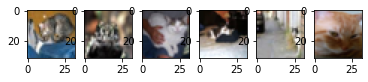

True class:
cat
Top 5 predicted:
['frog', 'cat', 'cat', 'cat', 'cat']
Average precision 0.3895509889772585



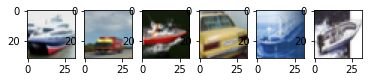

True class:
ship
Top 5 predicted:
['truck', 'ship', 'automobile', 'ship', 'ship']
Average precision 0.6923174395098223



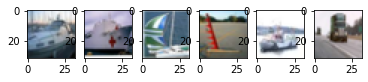

True class:
ship
Top 5 predicted:
['ship', 'ship', 'ship', 'ship', 'truck']
Average precision 0.5212035766234985



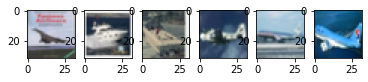

True class:
airplane
Top 5 predicted:
['ship', 'ship', 'airplane', 'airplane', 'airplane']
Average precision 0.35135058764819505



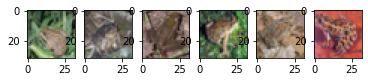

True class:
frog
Top 5 predicted:
['frog', 'frog', 'frog', 'frog', 'frog']
Average precision 0.795778444460085



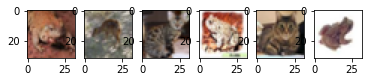

True class:
frog
Top 5 predicted:
['deer', 'cat', 'frog', 'cat', 'frog']
Average precision 0.28042266509673736



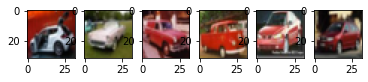

True class:
automobile
Top 5 predicted:
['automobile', 'automobile', 'truck', 'automobile', 'automobile']
Average precision 0.8034584877846597



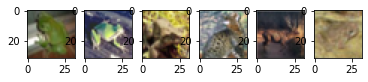

True class:
frog
Top 5 predicted:
['frog', 'frog', 'cat', 'deer', 'frog']
Average precision 0.357787963744995



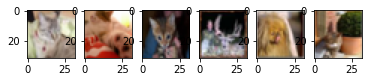

True class:
cat
Top 5 predicted:
['cat', 'cat', 'deer', 'dog', 'cat']
Average precision 0.3004930895250719



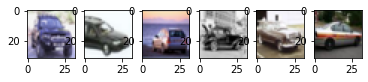

True class:
automobile
Top 5 predicted:
['automobile', 'automobile', 'automobile', 'automobile', 'automobile']
Average precision 0.8432601913436875



In [36]:
for k in range(10):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]

    plt.subplot(1, 6, 1)
    plt.imshow(test_dataset.data[k])
    for l in range(5):
      plt.subplot(1, 6, 2 + l)
      plt.imshow(test_images[sorted_idx[l]])
    plt.show() 
    
    
    print("True class:")
    print(classes[test_labels[k]])
    print("Top 5 predicted:")
    print([classes[test_dataset.targets[i]] for i in sorted_idx[:5]]) 
    print("Average precision {}".format(average_precision(test_labels[sorted_idx], test_labels[k])))
    print()

In [37]:
N_mAP = test_images.shape[0]
mAP = 0.0
for k in range(N_mAP):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]
    mAP += average_precision(test_labels[sorted_idx], test_labels[k])
mAP /= N_mAP

print('mAP = {}'.format(mAP))


mAP = 0.5455690919805486
